In [1]:
import time
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pytorch_lightning import LightningModule, Trainer
from dataset import ImageDataset
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall
from torchvision.models import resnet18
import warnings
from collections import defaultdict
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import cv2
from pytorch_lightning import Callback
from efficientnet_pytorch import EfficientNet


warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('medium')

from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
)
transform = Compose(
    [
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.5,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),]
)

class MyModel(LightningModule):
    def __init__(self, model, learning_rate=0.001, weight_decay=0.00005):
        super(MyModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()
        self.metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
        self.metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')
        self.train_loss = []
        self.valid_loss = []
        self.save_hyperparameters()


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        self.metric_precision(preds, labels)
        self.metric_recall(preds, labels)
        self.train_loss.append(loss.item())
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        self.metric_precision(preds, labels)
        self.metric_recall(preds, labels)
        self.valid_loss.append(loss.item())
        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, min_lr=5e-6, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def on_train_epoch_end(self):
        avg_loss = np.mean(self.train_loss)
        self.train_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.log('train_loss', avg_loss)


        self.log('train_precision 0', precision[0])
        self.log('train_recall 0 ', recall[0])

        self.log('train_precision 1', precision[1])
        self.log('train_recall 1' , recall[1])


        self.log('train_precision 2', precision[2])
        self.log('train_recall 2', recall[2])

        self.log('train_precision 3', precision[3])
        self.log('train_recall 3', recall[3])



        print(f'eloss: {avg_loss}')
    
    def on_validation_epoch_end(self):
        avg_loss = np.mean(self.valid_loss)
        self.valid_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.log('val_loss', avg_loss)


        self.log('val_precision 0', float(precision[0]))
        self.log('val_recall 0 ', recall[0])

        self.log('val_precision 1', precision[1])
        self.log('val_recall 1' , recall[1])


        self.log('val_precision 2', precision[2])
        self.log('val_recall 2', recall[2])

        self.log('valprecision 3', precision[3])
        self.log('tval_recall 3', recall[3])




        print(f'val_loss: {avg_loss} ')
    
torch.cuda.empty_cache()


batch_size = 64
trainset = ImageDataset(data_path='train_data', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=5)


testset =ImageDataset(data_path='validation_data')

testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=5)

learning_rate = 0.001
weight_decay = 0.00001




model = EfficientNet.from_name('efficientnet-b0', num_classes=4, in_channels=4)


C:\Users\adame\AppData\Local\Temp\ipykernel_13404\3155293630.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        self.metrics.append(trainer.logged_metrics.copy())

metrics_callback = MetricsCallback()

checkpoint = ModelCheckpoint(monitor="val_loss", mode="min")
lr_monitor = LearningRateMonitor("epoch")
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10)


lightning_model = MyModel(model, learning_rate, weight_decay)
trainer = Trainer(max_epochs=100, log_every_n_steps=1, accelerator='cuda', callbacks=[metrics_callback, lr_monitor, checkpoint, early_stop])
trainer.fit(lightning_model, trainloader, testloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | EfficientNet     | 4.0 M 
1 | criterion        | CrossEntropyLoss | 0     
2 | metric_precision | Precision        | 0     
3 | metric_recall    | Recall           | 0     
------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.052    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3874555826187134 


Training: |          | 0/? [00:00<?, ?it/s]

# Model loading - (this is the best model)

In [ ]:
ckpt_path = checkpoint.best_model_path
model = MyModel.load_from_checkpoint(ckpt_path) 
print(ckpt_path)

c:\Users\adame\Desktop\cells_master_thesis\lightning_logs\version_5\checkpoints\epoch=29-step=100710.ckpt


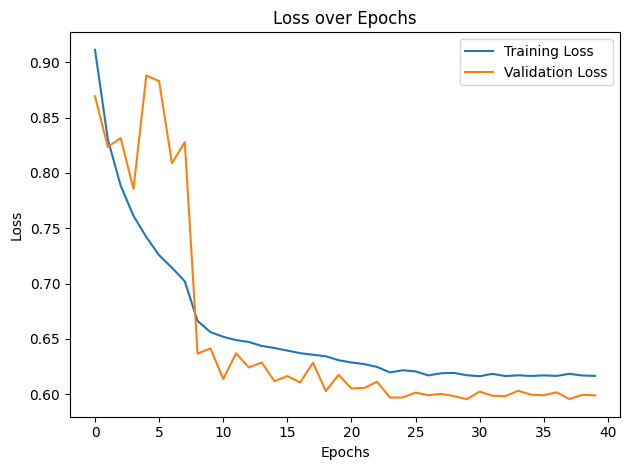

In [ ]:
metrics_dict = defaultdict(list)
for metrics in metrics_callback.metrics:
    for key, value in metrics.items():
        metrics_dict[key].append(value.item()) 

import matplotlib.pyplot as plt
# Plot loss
plt.plot(metrics_dict['train_loss'], label='Training Loss')
plt.plot(metrics_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import numpy as np
import torch 
from torchvision.models import resnet18
import torch.nn as nn


def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()

          

            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(y_pred)
        print(y_test)
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

testset =ImageDataset(data_path='test_data')
dataloader = DataLoader(testset, batch_size=1, shuffle=True)

test_report(model.to('cpu'), dataloader)

[1, 1, 3, 0, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 0, 3, 3, 0, 1, 3, 0, 0, 3, 1, 3, 1, 1, 3, 0, 1, 1, 0, 0, 3, 3, 2, 0, 1, 0, 3, 3, 3, 3, 0, 1, 3, 0, 1, 0, 0, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 0, 1, 0, 0, 3, 3, 1, 1, 3, 0, 1, 3, 1, 3, 0, 1, 1, 3, 0, 3, 3, 0, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 1, 3, 2, 2, 0, 1, 1, 0, 1, 3, 3, 0, 1, 1, 0, 0, 0, 3, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 1, 3, 3, 0, 0, 0, 3, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 3, 3, 0, 2, 1, 3, 3, 3, 3, 3, 0, 3, 3, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 3, 0, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 1, 3, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 3, 1, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 1, 3, 1, 3, 0, 0, 0, 3, 0, 1, 1, 1, 0, 3, 3, 1, 3, 2, 0, 1, 3, 1, 1, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 1, 3, 0, 1, 3, 0, 0, 3, 1, 1, 1, 

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Given NumPy array
arr = np.array([[177, 2, 1, 6],
                [2, 20, 6, 4],
                [1, 5, 219, 0],
                [6, 6, 0, 202]])

# Create a heatmap with values
sns.heatmap(arr, annot=True, fmt="d", cmap="YlGnBu")

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator("lightning_logs\version_5\events.out.tfevents.1709320553.AdamPC.12088.0")

NotFoundError: b'lightning_logs\x0bersion_5\\events.out.tfevents.1709320553.AdamPC.12088.0' does not point to valid Events file